In [94]:
# Imports
from compressors import lz77, huffman, lzw, arithmetic_code, utils
import os, email, re
from wordcloud import WordCloud, STOPWORDS
# Python numbers and plots
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
#Sklearn import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## 1. Pre processing email dataset

**Loading dataset**

In [110]:
# Loading emails csv
file_path = os.path.join(os.getcwd(), "dataset/emails.csv")
df = p.read_csv(file_path, nrows=20000)
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


Transform emails raw message in a dataframe, by extract all the meta informations from the `message` field. This extra information will be usefull for clustering and partitition, and **discarted** at the compression time (we will compress the raw `message`)

In [111]:
# Adapt raw emails to objects
emails = list(map(email.parser.Parser().parsestr, df['message']))

#Extract field names from email objects
columns = emails[0].keys()

# Exploding emails metadata columns
for c in columns:
    df[c] = [info[c] for info in emails]

# Extracting emails raw texts
df['body'] = list(map(lambda e : e.get_payload(), emails))

#rename column message, to indicate that this column has the unprocessed raw data
df = df.rename(columns={"message" : "Raw-Message"})

# Parsing dates
df['Date'] = p.to_datetime(df['Date'],infer_datetime_format=True)

display(df.head(5))

,file,Raw-Message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.


**Cleaning subject and body field** : These columns are key informations on the clusterization process. So it's important normalize the data by removing abreviations, terms included by the HTML compilation (and other indformation different then pure text, that could interfer on the data meaning).

In [112]:
# Sanitizing columns
def sanitize_column(data):
    '''
        Function to cleaning text for a better analysis
    '''
    #words to be excluded from s
    exclusions = ["re", "Re", "RE", "-", "_", "\n", r'[0-9]+', r'\[[^]]*\]', r'[^\w\s]', "forwarded by phillip k allenhouect on    pm"]
    # words to be replaced
    replaces = [(r"\'ve", " have "), (r"can\`t", "cannot"), (r"n't", " not "), (r"I'm", "I am"), (r"\'re", " are "), (r"\'d", " would "), (r"\'ll", " will ")]

    if data:
        for ex in exclusions:
            data = re.sub(ex, '', data)
        
        # strip html
        p = re.compile(r'<.*?>')

        for rep in replaces:
            data = re.sub(rep[0], rep[1], data)
        
        if 'forwarded by:' in data:
            data = data.split('subject')[1]

        data = p.sub('', data)

        #strip data
        data = data.strip()
        return data
    return "Empty"

df['Subject_sanitized'] = df['Subject'].apply(sanitize_column)
df['body_sanitized'] = df['body'].apply(sanitize_column)          


**Show clusters for subject and body**

In [113]:
stop_words = set(STOPWORDS)
extra_stop_words = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa','hou', 'cc', 'etc', 'subject', 'pm', 'ect', 'com', 'recipient', "Empty"]

for word in extra_stop_words:
    stop_words.add(word)

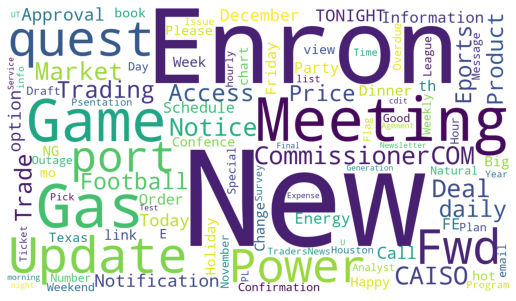

In [114]:
w_cloud = WordCloud(
    collocations=False,
    width=1400, height=800,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    random_state=42).generate(' '.join(df['Subject_sanitized']))

plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(w_cloud)
plt.axis('off')
plt.show()


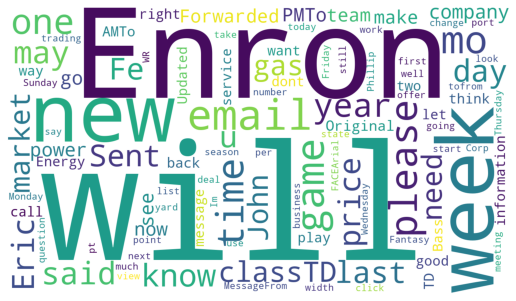

In [115]:
w_cloud = WordCloud(
    collocations=False,
    width=1400, height=800,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    random_state=42).generate(' '.join(df['body_sanitized']))

plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(w_cloud)
plt.axis('off')
plt.show()

## 2. Compressing data without clusterization partition

In [116]:
# Data to compress: Compress the original data raw
raw_text = df['Raw-Message']

#Shuffle raw text into 4 equal parts
shuffle = raw_text.sample(frac=1)
partitions = np.array_split(shuffle, 4)

In [117]:
#Initializing encoders
huffman_encoder = huffman.HuffmanCompressor(partitions[0].sum())
# ar_encoder = arithmetic_code.ArithmeticCompressor("Lá em casa tinha um piano, com um copo de veneno, quem bebeu morreu o culpado nao fui eu, foi o filho do abreu")
# lzw_encoder = lzw.LzwCompressor("Lá em casa tinha um piano, com um copo de veneno, quem bebeu morreu o culpado nao fui eu, foi o filho do abreu")
# lz77_encoder = lz77.Lz77Compressor("Lá em casa tinha um piano, com um copo de veneno, quem bebeu morreu o culpado nao fui eu, foi o filho do abreu")


In [118]:
#Encode by Huffman
huffman_encoder.encode(print_stats=True)
#Asserting that the text is being corrected decoded
assert huffman_encoder.originaltext == huffman_encoder.decode()

Average code size: 5.232145849238836
Orignal size (bytes): 13589375
New size (bytes): 8887699
Compression rate (%): 34.59817688451456


#### Plot results from non cluster data

***Compressed vs original text to each compressor***

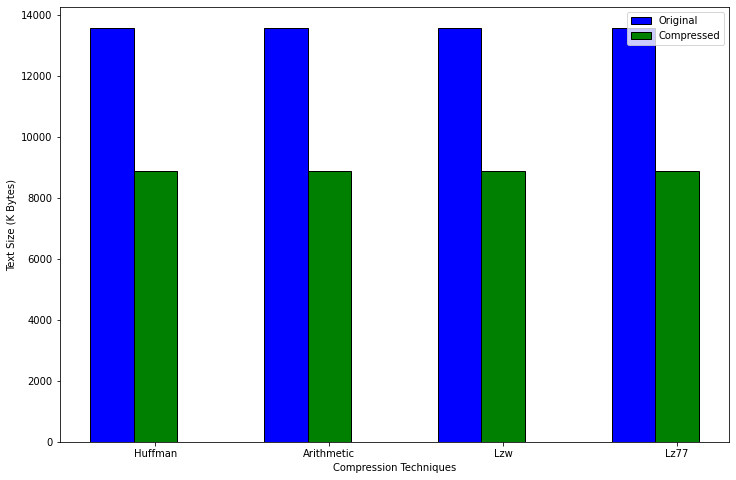

In [119]:
# Set the bar
bar_w = 0.25
fig, ax= plt.subplots(figsize = (12, 8))

def convert_to_kb(arr):
    return list(map(lambda x: x / 1000, arr))

# Data initialization
inputs = [huffman_encoder.stats.originaltextsize] * 4 # TODO
original_text_size = convert_to_kb(inputs)
results = [huffman_encoder.stats.compressedtextsize] * 4 # TODO
compressed_text_size = convert_to_kb(results)

# X axis position
original_text_bar = np.arange(len(original_text_size))
compressed_text_bar = [x + bar_w for x in original_text_bar]

# The Plot
plt.bar(original_text_bar, original_text_size, color='b', width=bar_w, edgecolor='black', label='Original')
plt.bar(compressed_text_bar, compressed_text_size, color='g', width=bar_w, edgecolor='black', label='Compressed')

# Lables
plt.xlabel('Compression Techniques', fontsize = 10)
plt.ylabel('Text Size (K Bytes)', fontsize = 10)
algs = ["Huffman", "Arithmetic", "Lzw", "Lz77"]
plt.xticks([r + bar_w for r in range(len(original_text_size))], algs)

plt.legend()
plt.show()

***Comparing compression rates***

/var/folders/b2/3n2dwwc92tl814w2xmqy38g40000gp/T/ipykernel_77612/1405862819.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color = 'gray', linestyle = '-.', linewidth = 0.5, alpha = 0.2)


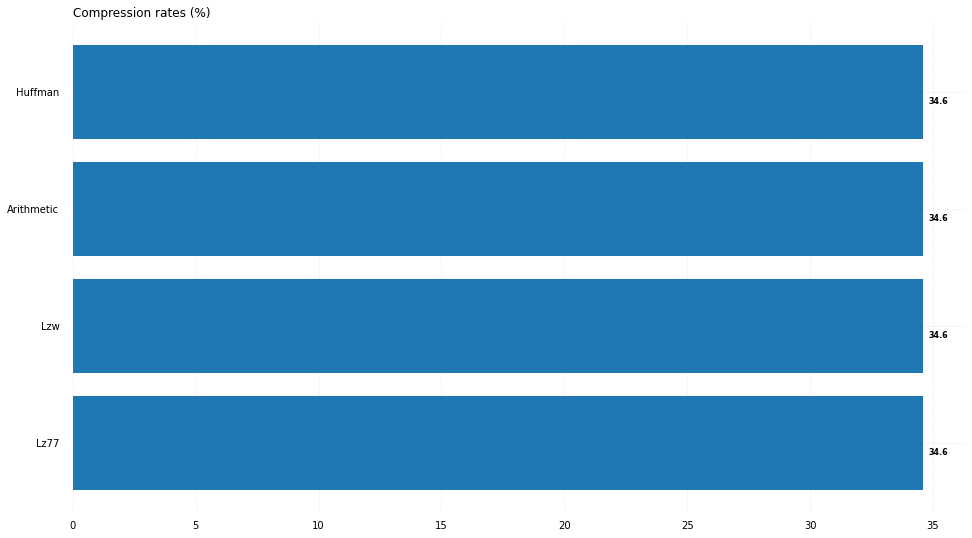

In [120]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
algs = ["Huffman", "Arithmetic", "Lzw", "Lz77"]
percents = [huffman_encoder.stats._compression_rate()] * 4 #TODO

# Bar plot for horizontal plot
ax.barh(algs, percents)

# Remove vertical bar settings
for dir in ['top', 'bottom', 'left', 'right']:
    ax.spines[dir].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Draw settings for horizontal bars settings
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color = 'gray', linestyle = '-.', linewidth = 0.5, alpha = 0.2)

# Top Values
ax.invert_yaxis()

# Add annotation
for index in ax.patches:
    plt.text(index.get_width()+0.2, index.get_y()+0.5, str(round((index.get_width()), 2)),
             fontsize = 8, fontweight ='bold', color ='black')

# Title
ax.set_title('Compression rates (%)', loc='left')

plt.show()
 

## 3. Compressing data with k-means clusterization

**TF/IDF Vectorization** : Relevant words score

In [121]:
data = df['body_sanitized']

tf_idf_vec = TfidfVectorizer(stop_words=stop_words, max_features=5000)

tf_idf = tf_idf_vec.fit_transform(data)
tf_idf_norm = normalize(tf_idf) # To PCA running
tf_idf_arr = tf_idf_norm.toarray()
p.DataFrame(tf_idf_arr, columns=tf_idf_vec.get_feature_names()).head(10)

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'empty', 'fw', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,aas,abc,abcsubstringabclengthdocumentwriteimg,ability,abinding,able,abramo,absence,absolutely,...,youve,ypc,yr,yvette,zdnet,zerilli,zero,zip,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**PCA components** : Transform dimensions to keep only meaningfull data

In [122]:
pca = PCA(n_components=2)
Y = pca.fit_transform(tf_idf_arr)

***Clusters visual analysis***

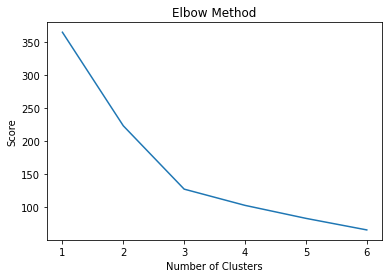

In [123]:
clusters = range(1, 7) # Range randomly defined just to analyse
n_kmeans = [KMeans(n_clusters=n) for n in clusters] # Create objects

score = [n_kmeans[n].fit(Y).score(Y) for n in range(len(n_kmeans))] # models training
score = [-i for i in score] # Normalize scores to plot

plt.plot(clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

**Create 4 clusters to data** : Divide data into 4 clusters in order to rum the compression algorithms

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

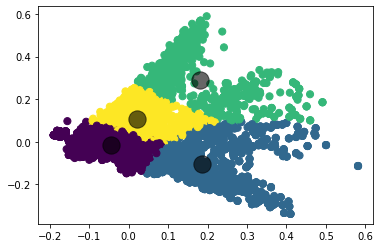

In [132]:
kmeans = KMeans(n_clusters=4)
fit_data = kmeans.fit(Y)
pred_class = kmeans.predict(Y)

display(pred_class)

# Ploting clusterization with bubble format
plt.scatter(Y[:, 0], Y[:, 1], c=pred_class, s=50, cmap='viridis')

centers = fit_data.cluster_centers_
plt.scatter(centers[:, 0], centers[:,1], c='black', s=300, alpha=0.6)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_featur

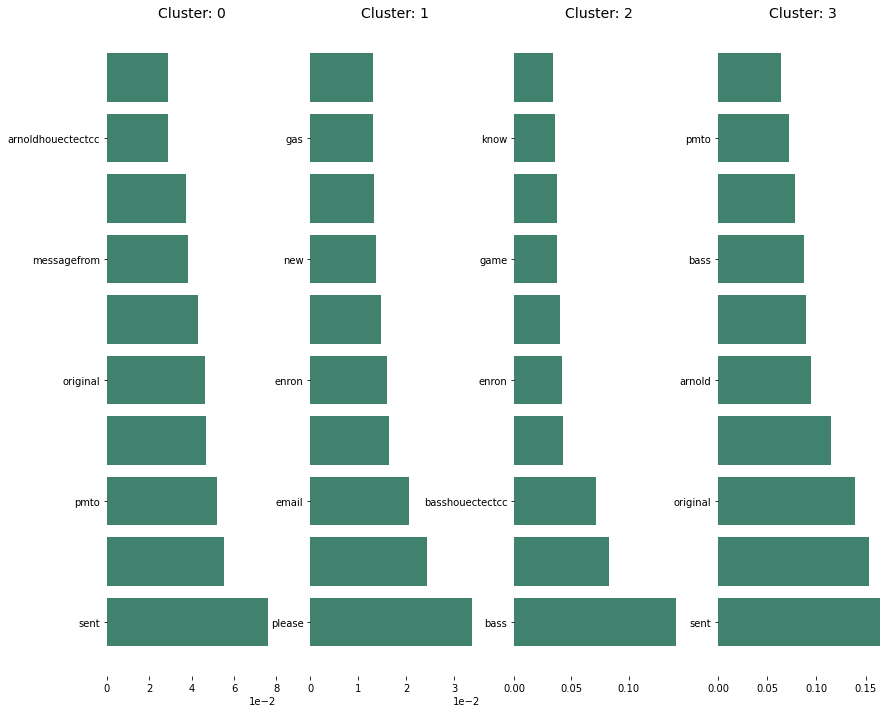

In [131]:
# Feacture extraction functions: The most used words in each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = p.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plot_features(df_s):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(df_s[0]))
    for i, df in enumerate(df_s):
        ax = fig.add_subplot(1, len(df_s), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        ax.set_yticklabels(df.features)
    plt.show()

df_cluster = get_top_features_cluster(tf_idf_arr, pred_class, 10)
plot_features(df_cluster)